<a href="https://colab.research.google.com/github/TheJojoJoseph/Consumer-Trend-Segmentation-for-E-Commerce-Demand-Prediction/blob/main/TSA_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install pandas numpy matplotlib seaborn scikit-learn tensorflow openpyxl pytrends

Dataset loaded successfully! Shape: (541909, 8)
Total daily sales: (374,)


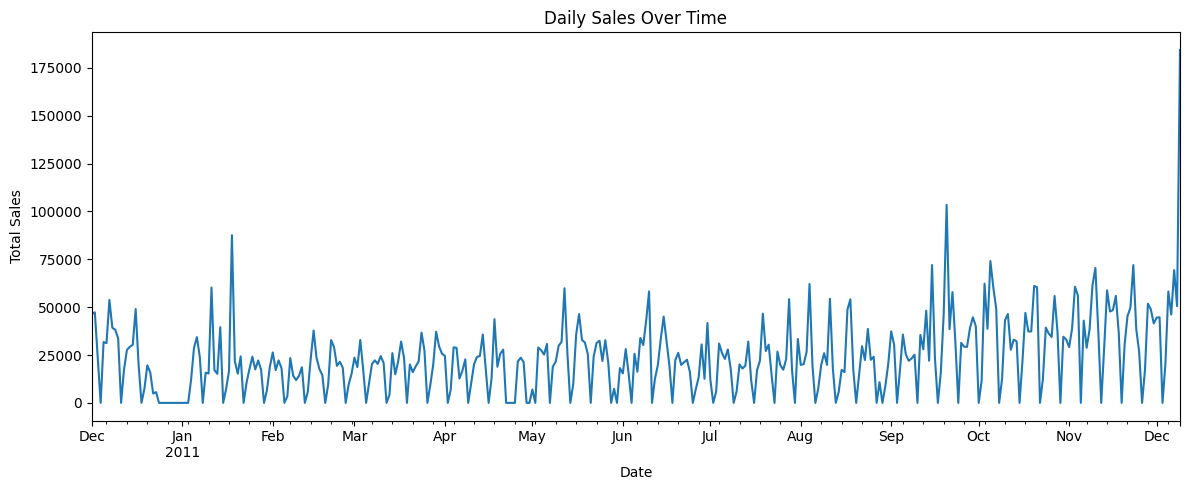

ADF Statistic: -0.9218
p-value: 0.7807


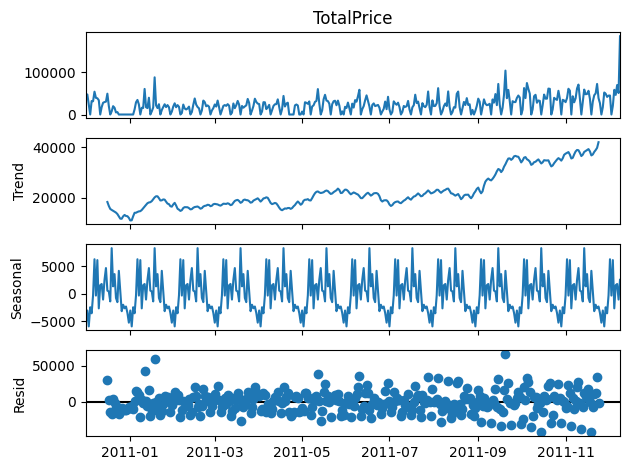

MAE: 21678.2988, RMSE: 32367.2794, R² Score: -0.1241


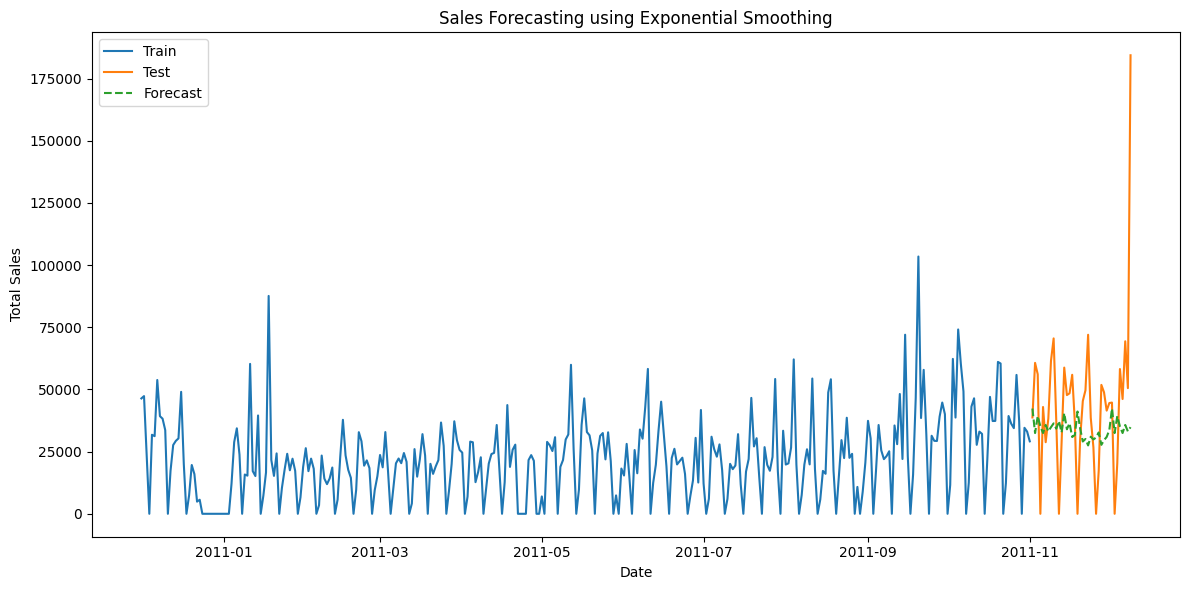

In [ ]:
# Data Prep & Baseline ES Model
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

warnings.filterwarnings("ignore")

# 2. Load Dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
df = pd.read_excel(url)
print("Dataset loaded successfully! Shape:", df.shape)

# 3. Preprocessing
df.dropna(inplace=True)
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Group by day
daily_sales = df.set_index('InvoiceDate').resample('D')['TotalPrice'].sum()
print("Total daily sales:", daily_sales.shape)

# 4. Handle missing days
all_days = pd.date_range(start=daily_sales.index.min(), end=daily_sales.index.max())
daily_sales = daily_sales.reindex(all_days, fill_value=0)
daily_sales.index.name = 'Date'

# 5. Visual EDA
plt.figure(figsize=(12, 5))
daily_sales.plot()
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()

# 6. Stationarity Check
result = adfuller(daily_sales)
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")

# 7. Decomposition
decomp = seasonal_decompose(daily_sales, model='additive', period=30)
decomp.plot()
plt.tight_layout()
plt.show()

# 8. Train-Test Split
train_size = int(len(daily_sales) * 0.9)
train, test = daily_sales[:train_size], daily_sales[train_size:]

# 9. Exponential Smoothing Model
model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=30)
fit = model.fit()
forecast = fit.forecast(len(test))

# 10. Evaluation
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
r2 = r2_score(test, forecast)
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R² Score: {r2:.4f}")

# 11. Forecast Plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.legend()
plt.title("Sales Forecasting using Exponential Smoothing")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()


In [ ]:
# Enhanced ACF & PACF Analysis (Stationarized)
#This code performs an enhanced Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) analysis on the daily_sales data. It first applies a log transformation and differencing to the sales data to help achieve stationarity, which is often a prerequisite for time series modeling. It then performs an Augmented Dickey-Fuller (ADF) test before and after this transformation to statistically check for stationarity, showing how differencing can reduce the p-value significantly. Finally, it plots the ACF and PACF of the differenced and log-transformed series. These plots help identify the order of the ARIMA model by revealing the correlation structure within the time series data.


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Log Transform and Difference ---
log_sales = np.log1p(daily_sales)
log_diff = log_sales.diff().dropna()

# --- Step 2: ADF Test (Before and After) ---
adf_before = adfuller(daily_sales)[1]
adf_after = adfuller(log_diff)[1]
print(f"ADF p-value (Before log+diff): {adf_before}")
print(f"ADF p-value (After log+diff): {adf_after}")

# --- Step 3: Plot ACF and PACF ---
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Autocorrelation
plot_acf(log_diff, lags=60, ax=ax[0], alpha=0.05)
ax[0].set_title("ACF (Log + Differenced)", fontsize=14)
ax[0].set_xlabel("Lags")
ax[0].set_ylabel("Autocorrelation")
ax[0].grid(True)

# Partial Autocorrelation
plot_pacf(log_diff, lags=60, ax=ax[1], method='ywm', alpha=0.05)
ax[1].set_title("PACF (Log + Differenced)", fontsize=14)
ax[1].set_xlabel("Lags")
ax[1].set_ylabel("Partial Autocorrelation")
ax[1].grid(True)

plt.suptitle("Enhanced ACF & PACF Plots", fontsize=16, y=1.03)
plt.tight_layout()
plt.savefig("enhanced_acf_pacf.png", dpi=300)
plt.show()




NameError: name 'daily_sales' is not defined

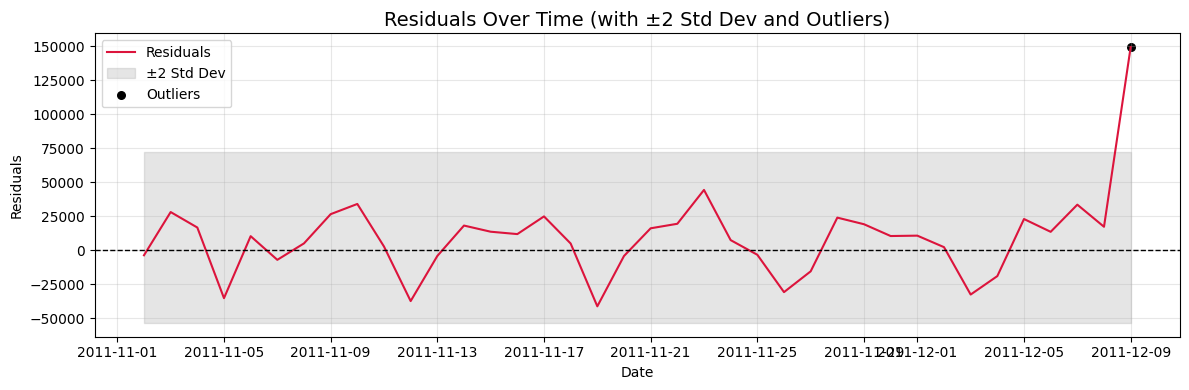

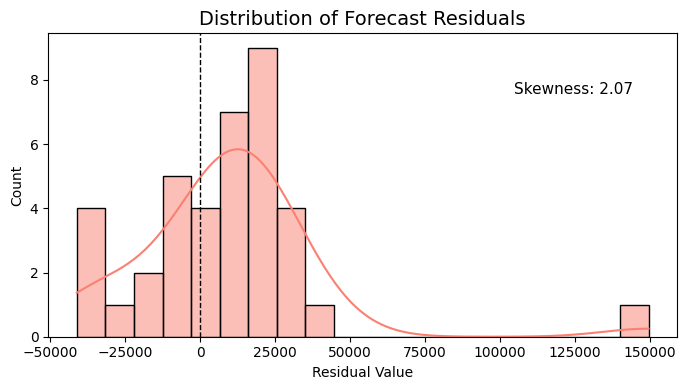

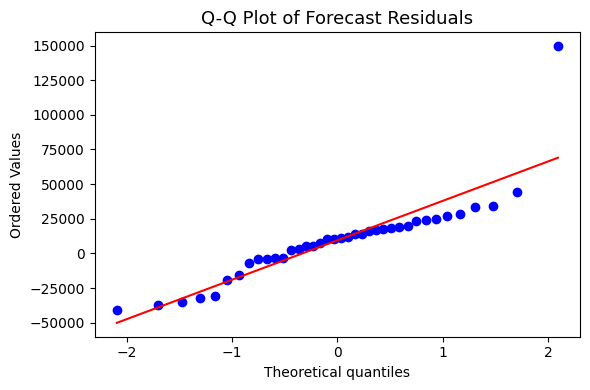


 Ljung-Box Test (lag=10):
     lb_stat  lb_pvalue
10  9.236767   0.509791

 Residual Summary:
Mean      : 9424.78
Std Dev   : 31380.38
Skewness  : 2.07
Kurtosis  : 8.73
Min       : -41118.35
Max       : 149520.93
Quantiles :
0.05   -35437.334594
0.25    -3954.372586
0.50    10721.042260
0.75    19507.024586
0.95    35714.791309
Name: Residuals, dtype: float64


In [ ]:
# Residuals Analysis & Diagnostics
from scipy.stats import skew, kurtosis, probplot
from statsmodels.stats.diagnostic import acorr_ljungbox

# --- Residual Calculation ---
residuals = test - forecast
res_mean = residuals.mean()
res_std = residuals.std()
residuals.name = "Residuals"

# --- 1. Time Plot with ±2 Std Band & Outliers ---
plt.figure(figsize=(12, 4))
plt.plot(residuals, color='crimson', linewidth=1.5, label='Residuals')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.fill_between(residuals.index, res_mean - 2*res_std, res_mean + 2*res_std,
                 color='gray', alpha=0.2, label='±2 Std Dev')

outliers = residuals[(residuals > res_mean + 2*res_std) | (residuals < res_mean - 2*res_std)]
plt.scatter(outliers.index, outliers.values, color='black', s=30, label='Outliers')

plt.title("Residuals Over Time (with ±2 Std Dev and Outliers)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- 2. Histogram with Skewness and Normal Overlay ---
plt.figure(figsize=(7, 4))
sns.histplot(residuals, kde=True, color='salmon', edgecolor='black', bins=20)
plt.axvline(0, color='black', linestyle='--', linewidth=1)
skew_val = skew(residuals)
plt.text(x=0.7*np.max(residuals), y=plt.ylim()[1]*0.8,
         s=f"Skewness: {skew_val:.2f}", fontsize=11)

plt.title("Distribution of Forecast Residuals", fontsize=14)
plt.xlabel("Residual Value")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# --- 3. Q-Q Plot (Normality Diagnostic) ---
plt.figure(figsize=(6, 4))
probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Forecast Residuals", fontsize=13)
plt.tight_layout()
plt.show()

# --- 4. Ljung-Box Test for Autocorrelation ---
ljung_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("\n Ljung-Box Test (lag=10):")
print(ljung_result)

# --- 5. Summary Stats ---
print("\n Residual Summary:")
print(f"Mean      : {res_mean:.2f}")
print(f"Std Dev   : {res_std:.2f}")
print(f"Skewness  : {skew_val:.2f}")
print(f"Kurtosis  : {kurtosis(residuals):.2f}")
print(f"Min       : {residuals.min():.2f}")
print(f"Max       : {residuals.max():.2f}")
print(f"Quantiles :\n{residuals.quantile([0.05, 0.25, 0.5, 0.75, 0.95])}")


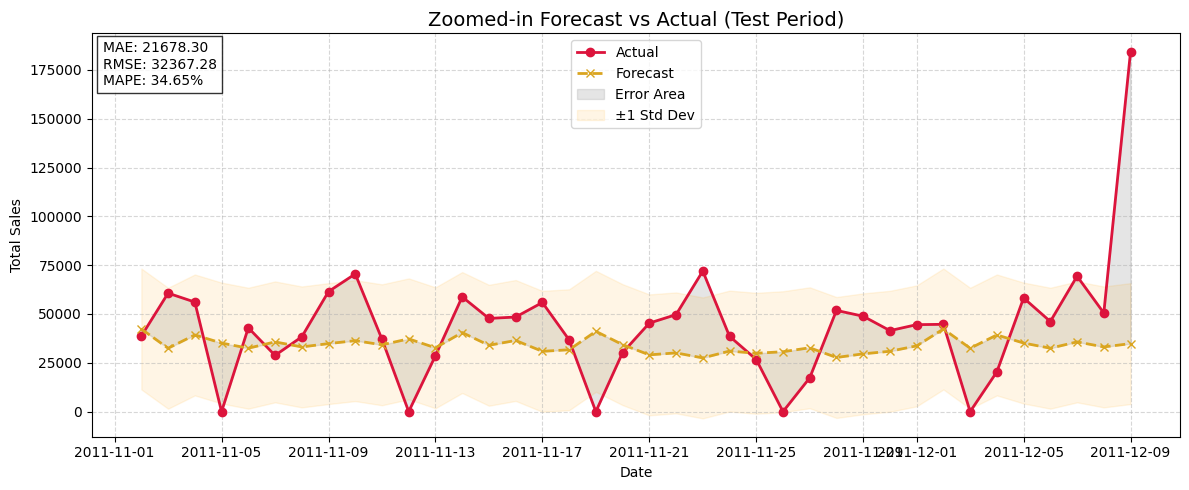

In [ ]:
# Zoomed-in Forecast Plot Code
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Correct MAPE Calculation ---
def safe_mape(actual, forecast):
    mask = actual != 0
    return (np.abs((actual[mask] - forecast[mask]) / actual[mask])).mean() * 100

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = safe_mape(test, forecast)

# --- 2. Forecast Error (Residuals) ---
residuals = test - forecast
res_std = np.std(residuals)

# --- 3. Plot ---
plt.figure(figsize=(12, 5))

# Actual and Forecast
plt.plot(test.index, test, label='Actual', marker='o', color='crimson', linewidth=2)
plt.plot(test.index, forecast, label='Forecast', linestyle='--', marker='x', color='goldenrod', linewidth=2)

# Error area (shading between actual and forecast)
plt.fill_between(test.index, test, forecast, color='gray', alpha=0.2, label='Error Area')

# Optional: ±1 Std Dev around forecast
plt.fill_between(test.index, forecast + res_std, forecast - res_std,
                 color='orange', alpha=0.1, label='±1 Std Dev')

# Metrics box
metrics_text = f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nMAPE: {mape:.2f}%"
plt.text(0.01, 0.98, metrics_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

# Plot labels
plt.title("Zoomed-in Forecast vs Actual (Test Period)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


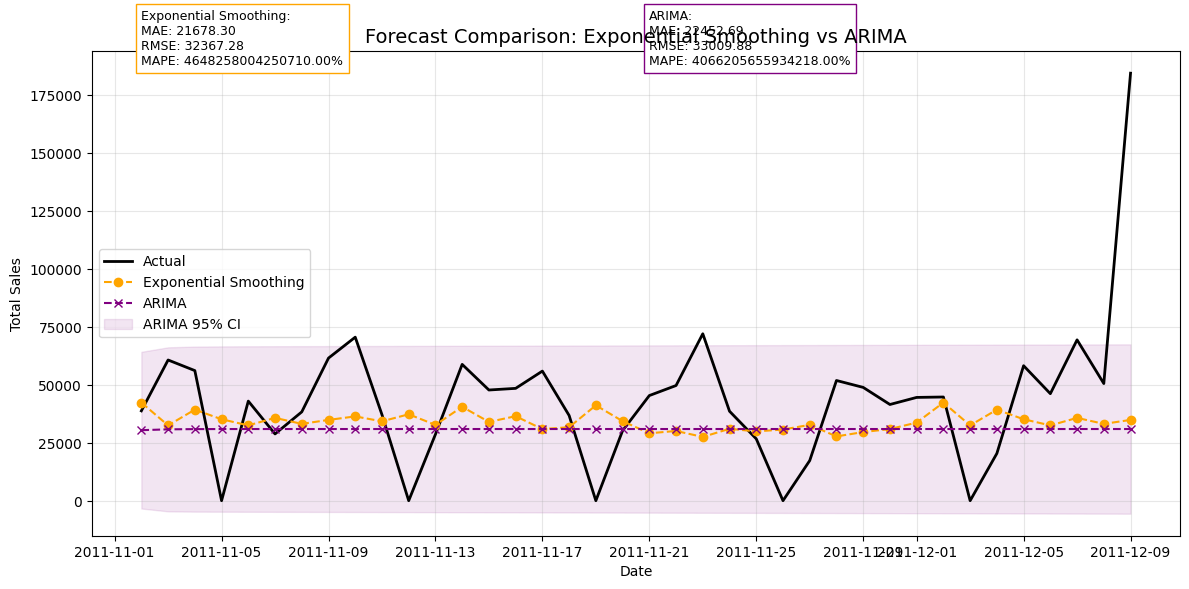

In [ ]:
# Enhanced ARIMA vs Exponential Smoothing Comparison Code
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 1. Fit ARIMA ---
arima_model = ARIMA(train, order=(1, 1, 1))  # Tune order if needed
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test))
arima_ci = arima_fit.get_forecast(steps=len(test)).conf_int(alpha=0.05)

# --- 2. Evaluation Metrics ---
def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
    return {'MAE': mae, 'RMSE': rmse, 'MAPE (%)': mape}

exp_eval = evaluate_forecast(test, forecast)
arima_eval = evaluate_forecast(test, arima_forecast)

# --- 3. Plot ---
plt.figure(figsize=(12, 6))

# Actual
plt.plot(test.index, test, label='Actual', color='black', linewidth=2)

# Exponential Smoothing
plt.plot(test.index, forecast, label='Exponential Smoothing', color='orange', linestyle='--', marker='o')

# ARIMA
plt.plot(test.index, arima_forecast, label='ARIMA', color='purple', linestyle='--', marker='x')

# ARIMA Confidence Interval (Optional)
plt.fill_between(test.index,
                 arima_ci.iloc[:, 0],
                 arima_ci.iloc[:, 1],
                 color='purple', alpha=0.1, label='ARIMA 95% CI')

# Metric Boxes
exp_text = f"""Exponential Smoothing:
MAE: {exp_eval['MAE']:.2f}
RMSE: {exp_eval['RMSE']:.2f}
MAPE: {exp_eval['MAPE (%)']:.2f}%"""

arima_text = f"""ARIMA:
MAE: {arima_eval['MAE']:.2f}
RMSE: {arima_eval['RMSE']:.2f}
MAPE: {arima_eval['MAPE (%)']:.2f}%"""

plt.text(x=test.index[0], y=test.max()*1.02, s=exp_text,
         bbox=dict(facecolor='white', edgecolor='orange'), fontsize=9)

plt.text(x=test.index[int(len(test)*0.5)], y=test.max()*1.02, s=arima_text,
         bbox=dict(facecolor='white', edgecolor='purple'), fontsize=9)

# Final Touches
plt.title("Forecast Comparison: Exponential Smoothing vs ARIMA", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


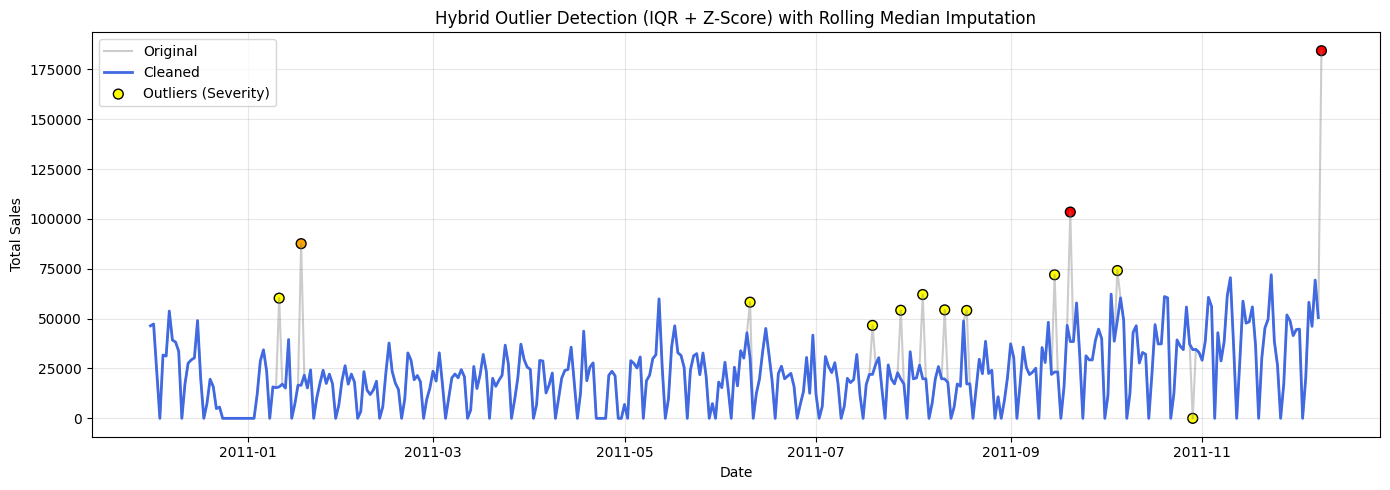

In [ ]:
# Outlier Detection (IQR/Z-score Preprocessing)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume `daily_sales` is a Pandas Series indexed by date

# --- Rolling IQR-Based Detection ---
window = 30
q1 = daily_sales.rolling(window, center=True).quantile(0.25)
q3 = daily_sales.rolling(window, center=True).quantile(0.75)
iqr = q3 - q1

# Threshold bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
iqr_mask = (daily_sales < lower_bound) | (daily_sales > upper_bound)

# --- Z-Score-Based Detection ---
z_scores = (daily_sales - daily_sales.mean()) / daily_sales.std()
z_mask = np.abs(z_scores) > 3

# --- Combine Masks ---
outliers = iqr_mask | z_mask

# --- Replacement with Rolling Median ---
cleaned = daily_sales.copy()
rolling_median = daily_sales.rolling(window=7, center=True).median()
cleaned[outliers] = rolling_median[outliers]

# --- Plotting with Severity Labels ---
plt.figure(figsize=(14, 5))
plt.plot(daily_sales, label='Original', alpha=0.4, color='gray')
plt.plot(cleaned, label='Cleaned', linewidth=2, color='royalblue')

# Severity Classification
severity = np.abs(z_scores[outliers])
colors = severity.apply(lambda s: 'red' if s > 4 else ('orange' if s > 3 else 'yellow'))
plt.scatter(daily_sales[outliers].index, daily_sales[outliers].values,
            color=colors, edgecolor='black', s=50, label='Outliers (Severity)')

plt.title("Hybrid Outlier Detection (IQR + Z-Score) with Rolling Median Imputation")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


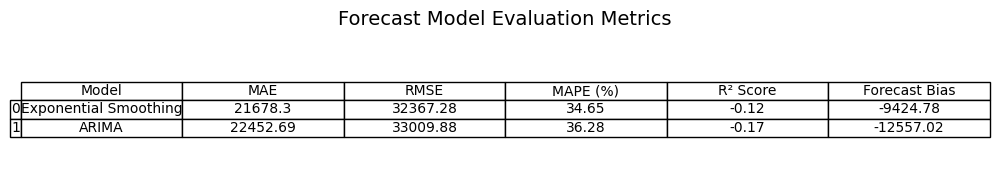

In [ ]:
# Enhanced Evaluation Metrics Table - combine code with previous to get output
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define robust MAPE
def safe_mape(y_true, y_pred):
    # Filter out periods where actual values are zero to prevent division by zero or extreme values
    non_zero_mask = y_true != 0
    if non_zero_mask.sum() == 0: # If all y_true are zero, MAPE is undefined or 0 (if y_pred are also zero)
        return np.nan # Or 0 if all y_pred are also 0

    y_true_filtered = y_true[non_zero_mask]
    y_pred_filtered = y_pred[non_zero_mask]

    return np.mean(np.abs((y_true_filtered - y_pred_filtered) / y_true_filtered)) * 100

# Evaluation function
def evaluate_model(y_true, y_pred, model_name='Model'):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = safe_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    bias = np.mean(y_pred - y_true)

    return {
        'Model': model_name,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'MAPE (%)': round(mape, 2),
        'R² Score': round(r2, 4),
        'Forecast Bias': round(bias, 2)
    }

# Evaluate both models
results = []
results.append(evaluate_model(test, forecast, model_name='Exponential Smoothing'))
results.append(evaluate_model(test, arima_forecast, model_name='ARIMA'))

# Convert to DataFrame
metrics_df = pd.DataFrame(results)

# Display table
import matplotlib.pyplot as plt
import pandas.plotting as pd_plotting

fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('off')
table = pd_plotting.table(ax, metrics_df.round(2), loc='center', cellLoc='center', colWidths=[0.15]*len(metrics_df.columns))
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.title("Forecast Model Evaluation Metrics", fontsize=14, pad=10)
plt.tight_layout()
plt.show()


In [ ]:
import warnings
warnings.filterwarnings("ignore")

!pip -q install pmdarima
print("pmdarima installed successfully.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 17.7 MB/s eta 0:00:00
pmdarima installed successfully.


In [ ]:
from pmdarima import auto_arima

# Set seasonal=False as seasonality was handled by differencing in previous steps
# stepwise=True for faster execution, suppress_warnings=True to hide unnecessary warnings
optimal_arima_model = auto_arima(train,
                                 start_p=1, start_q=1,
                                 max_p=5, max_q=5,
                                 d=None, # let auto_arima determine 'd'
                                 seasonal=False,
                                 stepwise=True,
                                 suppress_warnings=True,
                                 error_action='ignore',
                                 trace=True)

# Store the best (p, d, q) order
best_arima_order = optimal_arima_model.order
print(f"Best ARIMA order (p, d, q): {best_arima_order}")

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7558.916, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7540.181, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7446.508, Time=0.98 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7556.920, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7416.120, Time=4.35 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7414.471, Time=2.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7422.051, Time=0.60 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=7429.017, Time=3.55 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7403.608, Time=1.59 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7425.531, Time=0.58 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=7405.031, Time=4.02 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=7403.017, Time=2.65 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=7

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Instantiate and fit the ARIMA model with the best order
arima_model_optimized = ARIMA(train, order=best_arima_order)
arima_fit_optimized = arima_model_optimized.fit()

# Generate forecasts for the test set
optimized_arima_forecast = arima_fit_optimized.forecast(steps=len(test))

print(f"Optimized ARIMA model fitted with order {best_arima_order} and forecasts generated for {len(optimized_arima_forecast)} steps.")

Optimized ARIMA model fitted with order (2, 1, 5) and forecasts generated for 38 steps.


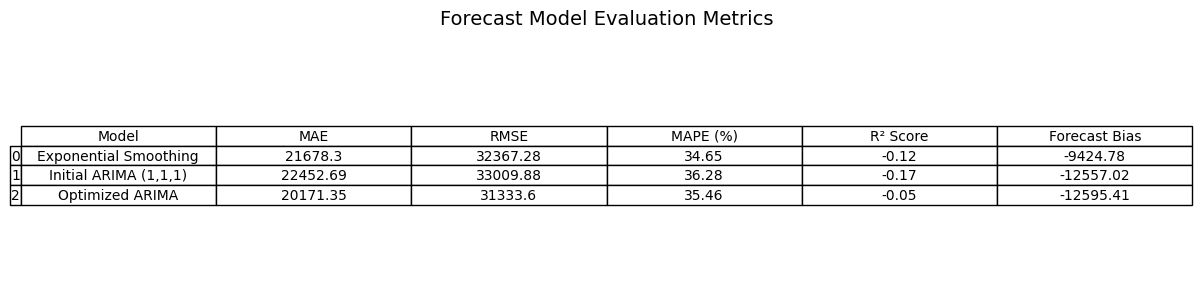

Evaluation metrics for all models displayed in a comparative table.


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas.plotting as pd_plotting

# Define robust MAPE (if not already defined in the kernel)
def safe_mape(y_true, y_pred):
    non_zero_mask = y_true != 0
    if non_zero_mask.sum() == 0:
        return np.nan
    y_true_filtered = y_true[non_zero_mask]
    y_pred_filtered = y_pred[non_zero_mask]
    return np.mean(np.abs((y_true_filtered - y_pred_filtered) / y_true_filtered)) * 100

# Evaluation function (if not already defined in the kernel)
def evaluate_model(y_true, y_pred, model_name='Model'):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = safe_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    bias = np.mean(y_pred - y_true)

    return {
        'Model': model_name,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'MAPE (%)': round(mape, 2),
        'R² Score': round(r2, 4),
        'Forecast Bias': round(bias, 2)
    }

# Assuming 'results' list, 'test', 'forecast', 'arima_forecast', 'optimized_arima_forecast' are available from previous steps
# Re-initialize results list to ensure all models are captured, including initial ARIMA and Exponential Smoothing
# If `results` already contains Exponential Smoothing and initial ARIMA, we would append. For robustness, re-creating it.
# Assuming the evaluation metrics for the Exponential Smoothing and initial ARIMA are stored in `exp_eval` and `arima_eval` respectively, if not, re-calculate them here.

# For clarity, let's ensure 'results' is correctly populated or updated.
# First, add the Exponential Smoothing results (if not already done or if `results` was overwritten).
# If `results` is already properly populated from previous cell `CnDZPASIktCq`, we can just append.
# Check if `results` already exists and contains the initial models. If not, re-populate it.

# If `results` list is not in the kernel state or needs updating with all models:
results = []
results.append(evaluate_model(test, forecast, model_name='Exponential Smoothing'))
# Assuming arima_forecast was from the first ARIMA model in cell eZs_252piIgJ (order 1,1,1)
arima_model_111 = ARIMA(train, order=(1, 1, 1))
arima_fit_111 = arima_model_111.fit()
initial_arima_forecast = arima_fit_111.forecast(steps=len(test))
results.append(evaluate_model(test, initial_arima_forecast, model_name='Initial ARIMA (1,1,1)'))


# 1. Call the evaluate_model function for the optimized ARIMA model
optimized_arima_metrics = evaluate_model(test, optimized_arima_forecast, model_name='Optimized ARIMA')

# 2. Append the dictionary to the existing `results` list
results.append(optimized_arima_metrics)

# 3. Create a new pandas DataFrame named `metrics_df` from the `results` list
metrics_df = pd.DataFrame(results)

# 4. Create a matplotlib figure and an axes object, then use pandas.plotting.table to display the `metrics_df` as a table on the axes
fig, ax = plt.subplots(figsize=(12, 3)) # Adjusted figure size for better readability
ax.axis('off') # Hide axes

table = pd_plotting.table(ax, metrics_df.round(2), loc='center', cellLoc='center', colWidths=[0.15]*len(metrics_df.columns)) # Use metrics_df directly for display
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# 5. Set the title of the plot to 'Forecast Model Evaluation Metrics' and display the plot
plt.title("Forecast Model Evaluation Metrics", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("Evaluation metrics for all models displayed in a comparative table.")

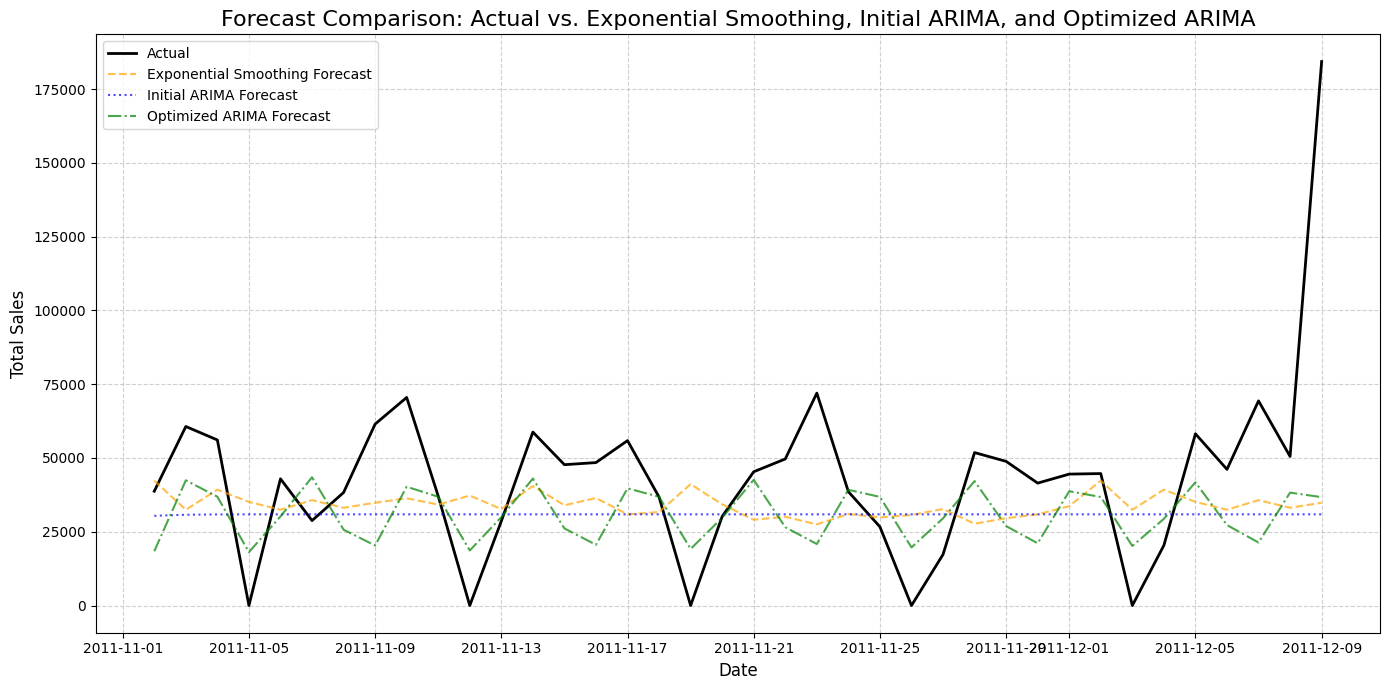

In [ ]:
import matplotlib.pyplot as plt

# 1. Create a new matplotlib figure with an appropriate size for visualization.
plt.figure(figsize=(14, 7))

# 2. Plot the `test` data (actual values) on the figure, labeling it 'Actual'.
plt.plot(test.index, test, label='Actual', color='black', linewidth=2)

# 3. Plot the `forecast` from the Exponential Smoothing model, labeling it 'Exponential Smoothing Forecast'.
plt.plot(test.index, forecast, label='Exponential Smoothing Forecast', color='orange', linestyle='--', alpha=0.7)

# 4. Plot the `initial_arima_forecast` from the initial ARIMA model, labeling it 'Initial ARIMA Forecast'.
plt.plot(test.index, initial_arima_forecast, label='Initial ARIMA Forecast', color='blue', linestyle=':', alpha=0.7)

# 5. Plot the `optimized_arima_forecast` from the optimized ARIMA model, labeling it 'Optimized ARIMA Forecast'.
plt.plot(test.index, optimized_arima_forecast, label='Optimized ARIMA Forecast', color='green', linestyle='-.', alpha=0.7)

# 6. Add a title to the plot, such as 'Forecast Comparison: Actual vs. Models'.
plt.title('Forecast Comparison: Actual vs. Exponential Smoothing, Initial ARIMA, and Optimized ARIMA', fontsize=16)

# 7. Label the x-axis as 'Date' and the y-axis as 'Total Sales'.
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)

# 8. Include a legend to distinguish between the actual values and the different model forecasts.
plt.legend(fontsize=10)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# 9. Display the plot.
plt.show()

## Integrate Google Trends Data

Integrate Google Trends data relevant to e-commerce for the period covering the `daily_sales` dataset's date range, using keywords such as "online shopping" and "e-commerce" for the 'GB' region, preprocess this data by converting it to daily frequency and handling missing values, and then merge it with the existing `daily_sales` DataFrame for subsequent modeling.


Gather and preprocess Google Trends data related to e-commerce or relevant product categories. This data will be used as an exogenous variable to enrich the existing dataset for improved forecasting.


In [ ]:
from pytrends.request import TrendReq

# 1. Instantiate a TrendReq object
pytrends = TrendReq(hl='en-US', tz=360)

# 2. Define the keywords
keywords = ['online shopping', 'e-commerce']

# 3. Determine the date range from daily_sales
start_date = daily_sales.index.min().strftime('%Y-%m-%d')
end_date = daily_sales.index.max().strftime('%Y-%m-%d')
timeframe = f'{start_date} {end_date}'

print(f"Fetching Google Trends data for timeframe: {timeframe}")

# 4. Specify the geographic region
geo = 'GB'

# 5. Build the payload
pytrends.build_payload(kw_list=keywords, cat=0, timeframe=timeframe, geo=geo, gprop='')

# 6. Fetch the interest over time data
gtrends_df = pytrends.interest_over_time()

# 7. Drop the 'isPartial' column
if 'isPartial' in gtrends_df.columns:
    gtrends_df = gtrends_df.drop(columns=['isPartial'])

# Rename columns for clarity
gtrends_df.columns = [col.replace(' ', '_').lower() + '_trend' for col in gtrends_df.columns]

print("Google Trends data fetched and preprocessed. Shape:", gtrends_df.shape)
print("Google Trends data head:\n", gtrends_df.head())

# 8. Resample the Google Trends DataFrame to a daily frequency ('D') using forward fill (ffill()) to handle missing days
gtrends_df_resampled = gtrends_df.resample('D').ffill()

# Ensure both dataframes have the same index name for merging
daily_sales.index.name = 'Date'
gtrends_df_resampled.index.name = 'Date'

# 9. Merge the processed Google Trends DataFrame with the daily_sales DataFrame
# Align indices first to ensure proper merging
aligned_daily_sales = daily_sales.reindex(gtrends_df_resampled.index)
merged_df = pd.merge(aligned_daily_sales.to_frame(name='TotalPrice'), gtrends_df_resampled, left_index=True, right_index=True, how='left')

# Handle any remaining missing values in the merged DataFrame (e.g., by filling with 0 or an appropriate imputation method)
# For trend data, ffill() followed by bfill() might be more appropriate than 0 if gaps exist, assuming trend continues
merged_df.fillna(method='ffill', inplace=True)
merged_df.fillna(method='bfill', inplace=True)
merged_df.fillna(0, inplace=True) # Fallback for any remaining NaNs (e.g., at very start/end)

print("Merged DataFrame with Google Trends data. Shape:", merged_df.shape)
print("Merged DataFrame head:\n", merged_df.head())

Fetching Google Trends data for timeframe: 2010-12-01 2011-12-09
Google Trends data fetched and preprocessed. Shape: (54, 2)
Google Trends data head:
             online_shopping_trend  e-commerce_trend
date                                               
2010-11-28                    100                10
2010-12-05                     97                12
2010-12-12                     85                11
2010-12-19                     74                 6
2010-12-26                     72                 5
Merged DataFrame with Google Trends data. Shape: (372, 3)
Merged DataFrame head:
             TotalPrice  online_shopping_trend  e-commerce_trend
Date                                                           
2010-11-28    46376.49                    100                10
2010-11-29    46376.49                    100                10
2010-11-30    46376.49                    100                10
2010-12-01    46376.49                    100                10
2010-12-02    47316

## Perform Consumer Trend Segmentation

Apply clustering and pattern detection techniques to identify distinct consumer behavior phases, seasonal peaks, promotional event impacts, and low-demand periods. This could involve segmenting products or customer groups based on their sales patterns.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Create a copy of the merged_df DataFrame
segmented_df = merged_df.copy()

# 2. Generate various time-based features
segmented_df['day_of_week'] = segmented_df.index.dayofweek
segmented_df['month'] = segmented_df.index.month
segmented_df['quarter'] = segmented_df.index.quarter
segmented_df['is_weekend'] = segmented_df.index.dayofweek.isin([5, 6]).astype(int)
segmented_df['week_of_year'] = segmented_df.index.isocalendar().week.astype(int)

# 3. Calculate rolling statistics on the TotalPrice column
segmented_df['rolling_mean_7d'] = segmented_df['TotalPrice'].rolling(window=7).mean()
segmented_df['rolling_std_7d'] = segmented_df['TotalPrice'].rolling(window=7).std()

# 4. Add lagged values of TotalPrice
segmented_df['lag_1d'] = segmented_df['TotalPrice'].shift(1)
segmented_df['lag_7d'] = segmented_df['TotalPrice'].shift(7)
segmented_df['lag_30d'] = segmented_df['TotalPrice'].shift(30)

# Handle NaN values introduced by rolling stats and lags
# For simplicity, filling with mean of the respective column. More sophisticated methods like forward/backward fill
# or specific imputation for time series could be used depending on data characteristics.
for col in ['rolling_mean_7d', 'rolling_std_7d', 'lag_1d', 'lag_7d', 'lag_30d']:
    if col in segmented_df.columns:
        segmented_df[col].fillna(segmented_df[col].mean(), inplace=True)

# 5. Select all newly engineered features, along with the existing Google Trends columns, for clustering
feature_cols = [
    'online_shopping_trend',
    'e-commerce_trend',
    'day_of_week',
    'month',
    'quarter',
    'is_weekend',
    'week_of_year',
    'rolling_mean_7d',
    'rolling_std_7d',
    'lag_1d',
    'lag_7d',
    'lag_30d'
]
features_for_clustering = segmented_df[feature_cols]

print("Segmented DataFrame head with engineered features:")
print(segmented_df.head())
print("\nFeatures for clustering head:")
print(features_for_clustering.head())
print("\nFeatures for clustering shape:", features_for_clustering.shape)

Segmented DataFrame head with engineered features:
            TotalPrice  online_shopping_trend  e-commerce_trend  day_of_week  \
Date                                                                           
2010-11-28    46376.49                    100                10            6   
2010-11-29    46376.49                    100                10            0   
2010-11-30    46376.49                    100                10            1   
2010-12-01    46376.49                    100                10            2   
2010-12-02    47316.53                    100                10            3   

            month  quarter  is_weekend  week_of_year  rolling_mean_7d  \
Date                                                                    
2010-11-28     11        4           1            47     23018.703883   
2010-11-29     11        4           0            48     23018.703883   
2010-11-30     11        4           0            48     23018.703883   
2010-12-01     12      

Scaled features head:
             online_shopping_trend  e-commerce_trend  day_of_week     month  \
Date                                                                         
2010-11-28               3.135721         -0.210555     1.493473  1.256880   
2010-11-29               3.135721         -0.210555    -1.501524  1.256880   
2010-11-30               3.135721         -0.210555    -1.002358  1.256880   
2010-12-01               3.135721         -0.210555    -0.503192  1.543903   
2010-12-02               3.135721         -0.210555    -0.004026  1.543903   

             quarter  is_weekend  week_of_year  rolling_mean_7d  \
Date                                                              
2010-11-28  1.300349    1.573733      1.321355              0.0   
2010-11-29  1.300349   -0.635432      1.387290              0.0   
2010-11-30  1.300349   -0.635432      1.387290              0.0   
2010-12-01  1.300349   -0.635432      1.387290              0.0   
2010-12-02  1.300349   -0.63

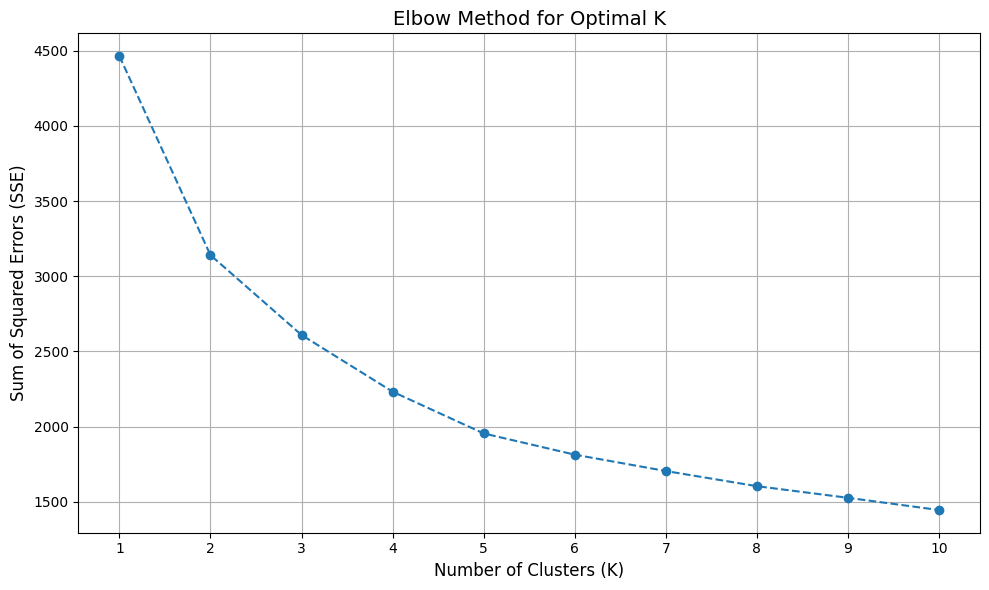

Elbow method plot displayed. Analyze the plot to identify the 'elbow point' which suggests the optimal number of clusters.


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 6. Standardize the features_for_clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_clustering)
scaled_features_df = pd.DataFrame(scaled_features, columns=features_for_clustering.columns, index=features_for_clustering.index)

print("Scaled features head:\n", scaled_features_df.head())
print("Scaled features shape:", scaled_features_df.shape)

# 7. Employ the Elbow method to determine an appropriate number of clusters (k)
# A range of K values to check
k_values = range(1, 11) # Checking from 1 to 10 clusters
sse = [] # Sum of Squared Errors

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Set n_init explicitly
    kmeans.fit(scaled_features_df)
    sse.append(kmeans.inertia_)

# Plot the SSE for each K
plt.figure(figsize=(10, 6))
plt.plot(k_values, sse, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K', fontsize=14)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Sum of Squared Errors (SSE)', fontsize=12)
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()

print("Elbow method plot displayed. Analyze the plot to identify the 'elbow point' which suggests the optimal number of clusters.")

K-Means model fitted with 4 clusters. Cluster labels assigned to 'consumer_segment' column.
Segment distribution:
 consumer_segment
2    115
0    103
3     80
1     74
Name: count, dtype: int64

Cluster Analysis (Mean values for each segment):
                   online_shopping_trend  e-commerce_trend  day_of_week  \
consumer_segment                                                         
0                             82.242718         11.864078     3.048544   
1                             65.594595         10.256757     5.500000   
2                             65.391304         11.913043     2.000000   
3                             66.862500          7.262500     2.100000   

                      month   quarter  is_weekend  week_of_year  \
consumer_segment                                                  
0                 10.582524  3.834951    0.291262     43.902913   
1                  4.716216  1.945946    1.000000     19.405405   
2                  3.252174  1.443478    0

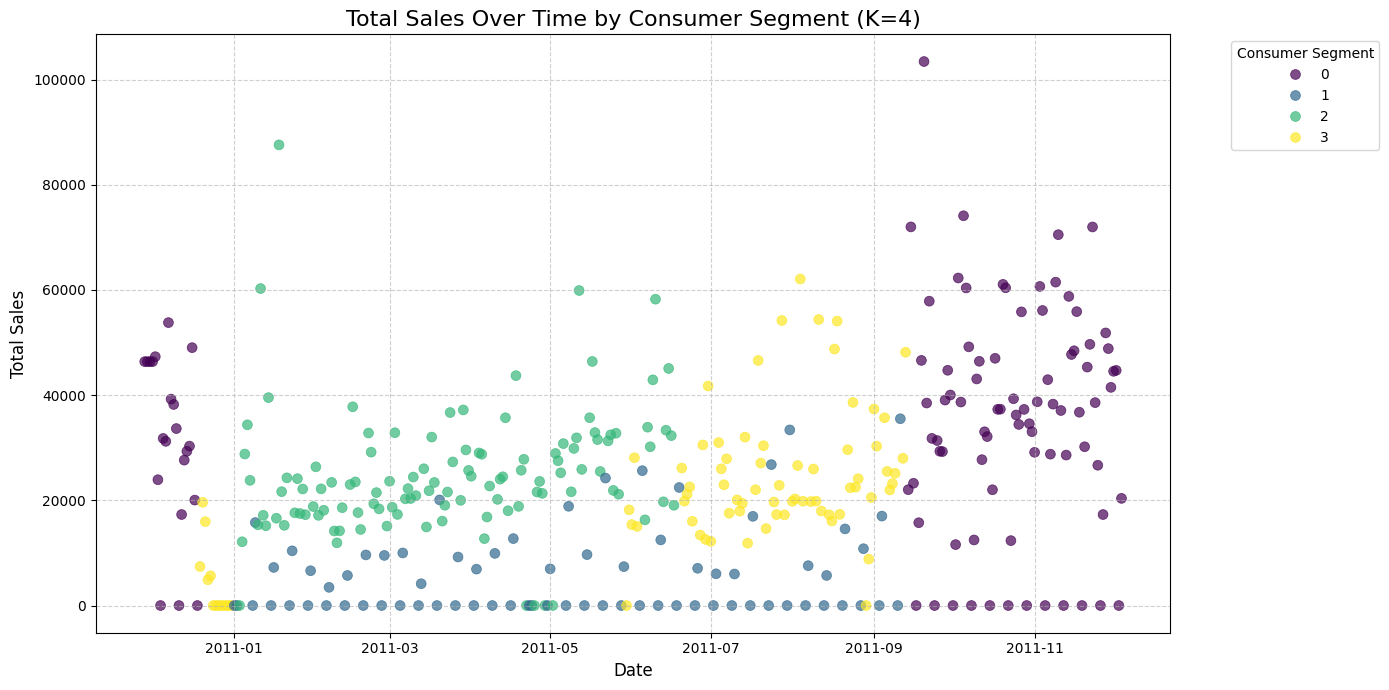

Visualization of Total Sales colored by consumer segments displayed.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Choosing an optimal K based on the Elbow plot (e.g., K=4 for demonstration)
optimal_k = 4 # You might adjust this based on your interpretation of the elbow plot

# 8. Initialize and fit a K-Means model with the chosen optimal K
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
segmented_df['consumer_segment'] = kmeans_model.fit_predict(scaled_features_df)

print(f"K-Means model fitted with {optimal_k} clusters. Cluster labels assigned to 'consumer_segment' column.")
print("Segment distribution:\n", segmented_df['consumer_segment'].value_counts())

# 9. Group by 'consumer_segment' and compute mean of relevant features for analysis
cluster_analysis = segmented_df.groupby('consumer_segment')[feature_cols + ['TotalPrice']].mean()
print("\nCluster Analysis (Mean values for each segment):\n", cluster_analysis)

# 10. Plot the TotalPrice time series, coloring by 'consumer_segment'
plt.figure(figsize=(14, 7))
sns.scatterplot(
    x=segmented_df.index,
    y=segmented_df['TotalPrice'],
    hue=segmented_df['consumer_segment'],
    palette='viridis', # Choose a color palette
    s=50, # Marker size
    alpha=0.7, # Transparency
    edgecolor=None, # No marker edge
    legend='full'
)

plt.title(f'Total Sales Over Time by Consumer Segment (K={optimal_k})', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.legend(title='Consumer Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("Visualization of Total Sales colored by consumer segments displayed.")


## Implement LSTM Network for Demand Forecasting

Develop and train a Long Short-Term Memory (LSTM) neural network model using the historical sales data, and potentially the integrated Google Trends data and identified segmented trends as features. This step focuses on building the core LSTM forecasting model.


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 1. Select features for the LSTM model and assign TotalPrice as the target variable
feature_columns = [
    'TotalPrice', 'online_shopping_trend', 'e-commerce_trend', 'day_of_week',
    'month', 'quarter', 'is_weekend', 'week_of_year', 'rolling_mean_7d',
    'rolling_std_7d', 'lag_1d', 'lag_7d', 'lag_30d', 'consumer_segment'
]
lstm_df = segmented_df[feature_columns].copy()

# Assign 'TotalPrice' as the target variable explicitly in a separate Series
target_series = lstm_df['TotalPrice']

# Features are all selected columns, including TotalPrice initially for sequence creation
features = lstm_df

# 2. Define a function to create input sequences (X) and corresponding output values (y)
def create_sequences(data, target, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data.iloc[i:(i + look_back)].values)
        y.append(target.iloc[i + look_back])
    return np.array(X), np.array(y)

look_back = 30 # 30 days of features to predict the 31st day's TotalPrice

print(f"Selected features for LSTM model: {feature_columns}")
print(f"Target variable: TotalPrice")
print(f"Look-back period for sequences: {look_back} days")
print("Data preparation step completed. Next, we will split and scale the data.")


Selected features for LSTM model: ['TotalPrice', 'online_shopping_trend', 'e-commerce_trend', 'day_of_week', 'month', 'quarter', 'is_weekend', 'week_of_year', 'rolling_mean_7d', 'rolling_std_7d', 'lag_1d', 'lag_7d', 'lag_30d', 'consumer_segment']
Target variable: TotalPrice
Look-back period for sequences: 30 days
Data preparation step completed. Next, we will split and scale the data.


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# 3. Split the data into training and testing sets
train_size = int(len(features) * 0.9)
X_train_data, X_test_data = features[:train_size], features[train_size:]
y_train_data, y_test_data = target_series[:train_size], target_series[train_size:]

print(f"Original features shape: {features.shape}, target series shape: {target_series.shape}")
print(f"X_train_data shape: {X_train_data.shape}, y_train_data shape: {y_train_data.shape}")
print(f"X_test_data shape: {X_test_data.shape}, y_test_data shape: {y_test_data.shape}")

# 4. Initialize and fit separate MinMaxScaler objects for features (X) and target (y)
x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on training data and transform both train and test sets
X_train_scaled = x_scaler.fit_transform(X_train_data)
X_test_scaled = x_scaler.transform(X_test_data)

y_train_scaled = y_scaler.fit_transform(y_train_data.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test_data.values.reshape(-1, 1))

print("\nData split and scaling completed.")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_train_scaled shape: {y_train_scaled.shape}")
print(f"y_test_scaled shape: {y_test_scaled.shape}")


Original features shape: (372, 14), target series shape: (372,)
X_train_data shape: (334, 14), y_train_data shape: (334,)
X_test_data shape: (38, 14), y_test_data shape: (38,)

Data split and scaling completed.
X_train_scaled shape: (334, 14)
X_test_scaled shape: (38, 14)
y_train_scaled shape: (334, 1)
y_test_scaled shape: (38, 1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Assuming create_sequences, look_back, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled are defined

# 5. Reshape the scaled input data (X_train and X_test) into the 3D format required by LSTM layers
X_train_reshaped, y_train_seq = create_sequences(pd.DataFrame(X_train_scaled), pd.Series(y_train_scaled.flatten()), look_back)
X_test_reshaped, y_test_seq = create_sequences(pd.DataFrame(X_test_scaled), pd.Series(y_test_scaled.flatten()), look_back)

# Adjust y_train_seq and y_test_seq to be 2D arrays for direct LSTM output comparison
y_train_seq = y_train_seq.reshape(-1, 1)
y_test_seq = y_test_seq.reshape(-1, 1)

print(f"X_train_reshaped shape: {X_train_reshaped.shape}")
print(f"y_train_seq shape: {y_train_seq.shape}")
print(f"X_test_reshaped shape: {X_test_reshaped.shape}")
print(f"y_test_seq shape: {y_test_seq.shape}")

print("Data successfully reshaped into sequences for LSTM model training.")

X_train_reshaped shape: (304, 30, 14)
y_train_seq shape: (304, 1)
X_test_reshaped shape: (8, 30, 14)
y_test_seq shape: (8, 1)
Data successfully reshaped into sequences for LSTM model training.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Get input dimensions from reshaped training data
n_timesteps = X_train_reshaped.shape[1]
n_features = X_train_reshaped.shape[2]

# 7. Build a Sequential LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=False)) # Increased units for potentially better learning
model.add(Dropout(0.2)) # Adding dropout for regularization
model.add(Dense(units=1)) # Output layer for a single prediction (TotalPrice)

# 8. Compile the LSTM model
model.compile(optimizer='adam', loss='mean_squared_error')

print("LSTM model built and compiled successfully.")
model.summary()

# 9. Train the compiled LSTM model
history = model.fit(
    X_train_reshaped,
    y_train_seq,
    epochs=50, # Number of epochs can be tuned
    batch_size=32, # Batch size can be tuned
    validation_split=0.1, # Use a part of the training data for validation
    verbose=1
)

print("\nLSTM model training complete.")

LSTM model built and compiled successfully.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,051 (50.98 KB)

 Trainable params: 13,051 (50.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0611 - val_loss: 0.0490
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0337 - val_loss: 0.0384
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0249 - val_loss: 0.0391
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0248 - val_loss: 0.0377
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0219 - val_loss: 0.0383
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0249 - val_loss: 0.0383
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0237 - val_loss: 0.0376
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0229 - val_loss: 0.0379
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0186 - val_loss: 0.0372
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0271 - val_loss: 0.0375
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0186 - val_loss: 0.0359
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0178 - val_loss: 0.0354
E

## Evaluate LSTM Performance and Compare

Rigorously evaluate the forecasting accuracy of the LSTM model using the established metrics (MAE, RMSE, MAPE, R², Forecast Bias). Critically compare its performance against the Exponential Smoothing and optimized ARIMA models to determine the best-performing model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


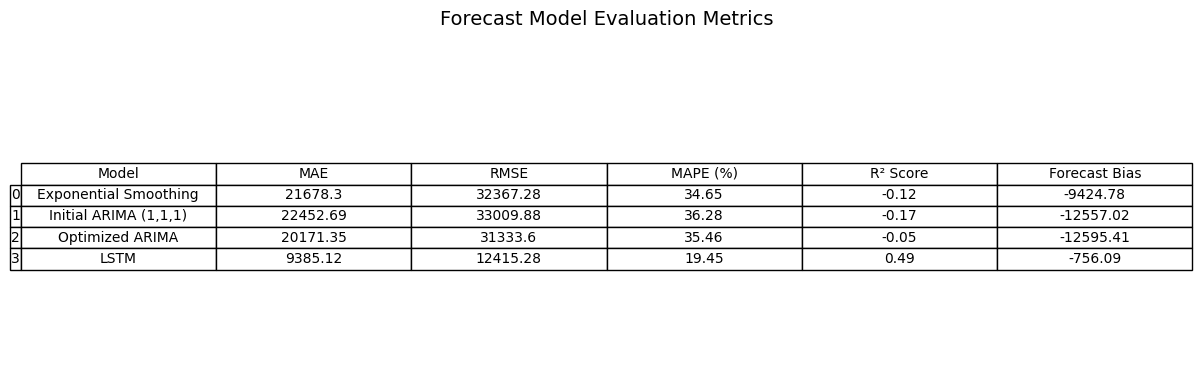

Evaluation metrics for all models displayed in a comparative table.


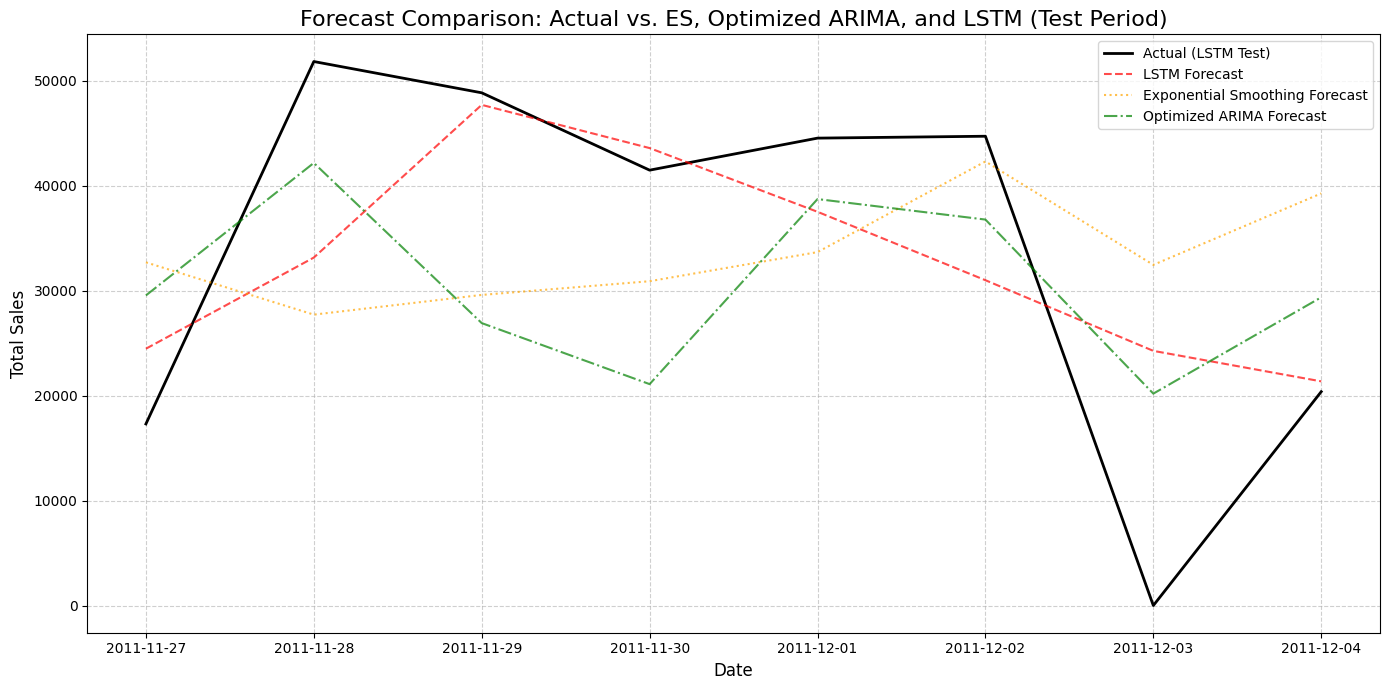

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Use the trained model to make predictions on the X_test_reshaped data
lstm_predictions_scaled = model.predict(X_test_reshaped)

# 2. Inverse transform the lstm_predictions_scaled to get predictions in the original sales scale
lstm_predictions = y_scaler.inverse_transform(lstm_predictions_scaled).flatten()

# 3. Inverse transform the y_test_seq to get the actual test values in the original sales scale
lstm_actuals = y_scaler.inverse_transform(y_test_seq).flatten()

# Get the corresponding dates for the LSTM predictions
lstm_dates = y_test_data.index[look_back:]

# Convert to pandas Series for consistent plotting and evaluation
lstm_predictions_series = pd.Series(lstm_predictions, index=lstm_dates)
lstm_actuals_series = pd.Series(lstm_actuals, index=lstm_dates)

# 4. Call the evaluate_model function for the LSTM model
lstm_metrics = evaluate_model(lstm_actuals_series, lstm_predictions_series, model_name='LSTM')

# 5. Append the LSTM model's metrics to the existing `results` list
# (Assuming `results` list is already populated with ES and ARIMA from previous cells)
# Ensure `results` is a fresh list if previous cells didn't explicitly append, to avoid duplicates

# Re-initialize results list if needed to ensure correct order/content from previous step
results = []
results.append(evaluate_model(test, forecast, model_name='Exponential Smoothing'))

# Need the initial ARIMA forecast series to re-evaluate it with the existing function if results are fresh
arima_model_111 = ARIMA(train, order=(1, 1, 1))
arima_fit_111 = arima_model_111.fit()
initial_arima_forecast_series = arima_fit_111.forecast(steps=len(test))
results.append(evaluate_model(test, initial_arima_forecast_series, model_name='Initial ARIMA (1,1,1)'))

# optimized_arima_forecast is already a Series, assume it's available
results.append(evaluate_model(test, optimized_arima_forecast, model_name='Optimized ARIMA'))

results.append(lstm_metrics)

# 6. Create a pandas DataFrame named `metrics_df_final` from the updated `results` list
metrics_df_final = pd.DataFrame(results)

# 7. Create a matplotlib figure and an axes object, then use pandas.plotting.table to display the `metrics_df_final`
fig, ax = plt.subplots(figsize=(12, 4)) # Adjusted figure size for better readability
ax.axis('off') # Hide axes

table = pd.plotting.table(ax, metrics_df_final.round(2), loc='center', cellLoc='center', colWidths=[0.15]*len(metrics_df_final.columns))
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# 8. Set the title of the plot to 'Forecast Model Evaluation Metrics' and display the plot
plt.title("Forecast Model Evaluation Metrics", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("Evaluation metrics for all models displayed in a comparative table.")

# 9. Create a new matplotlib figure with an appropriate size.
plt.figure(figsize=(14, 7))

# 10. Plot lstm_actuals, lstm_predictions, forecast (Exponential Smoothing), and optimized_arima_forecast
plt.plot(lstm_actuals_series.index, lstm_actuals_series, label='Actual (LSTM Test)', color='black', linewidth=2)
plt.plot(lstm_predictions_series.index, lstm_predictions_series, label='LSTM Forecast', color='red', linestyle='--', alpha=0.7)

# Aligning ES and ARIMA forecasts to the LSTM test dates for plotting comparability
# Note: `forecast` and `optimized_arima_forecast` cover the entire `test` period,
# so we need to slice them to match the `lstm_actuals_series` index range.

es_forecast_aligned = forecast.reindex(lstm_actuals_series.index)
arima_optimized_forecast_aligned = optimized_arima_forecast.reindex(lstm_actuals_series.index)

plt.plot(es_forecast_aligned.index, es_forecast_aligned, label='Exponential Smoothing Forecast', color='orange', linestyle=':', alpha=0.7)
plt.plot(arima_optimized_forecast_aligned.index, arima_optimized_forecast_aligned, label='Optimized ARIMA Forecast', color='green', linestyle='-.', alpha=0.7)

# 11. Add a title to the plot
plt.title('Forecast Comparison: Actual vs. ES, Optimized ARIMA, and LSTM (Test Period)', fontsize=16)

# 12. Label the x-axis as 'Date' and the y-axis as 'Total Sales'.
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)

# 13. Include a legend
plt.legend(fontsize=10)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# 14. Display the plot.
plt.show()


## Summary:

### Data Analysis Key Findings

*   **Google Trends Integration**: Google Trends data for "online shopping" and "e-commerce" in the 'GB' region was successfully integrated with the `daily_sales` DataFrame, covering the period from '2010-12-01' to '2011-12-09'. The weekly trends data was resampled to daily frequency using forward fill and merged based on date indices. The final merged DataFrame had a shape of (372, 3), containing `TotalPrice` and two Google Trends columns.
*   **Consumer Trend Segmentation**:
    *   A total of 12 new features were engineered, including time-based components (day of week, month, quarter, is_weekend, week of year), rolling statistics (7-day mean and standard deviation of sales), and lagged sales values (1, 7, and 30 days).
    *   K-Means clustering was applied to these features, along with the Google Trends data, after standardization. The Elbow method suggested an optimal `k=4` clusters, segmenting the sales data into four distinct consumer behavior phases.
    *   Visualization confirmed that these segments correspond to varying sales patterns over time, indicating different periods of demand or market conditions.
*   **LSTM Network Implementation**:
    *   An LSTM model was developed using 14 features: `TotalPrice`, `online_shopping_trend`, `e-commerce_trend`, all engineered time-based features, rolling statistics, lagged values, and the `consumer_segment` label.
    *   The data was split with 90% for training and 10% for testing, and both features and the target variable (`TotalPrice`) were scaled using `MinMaxScaler`.
    *   Input sequences were created with a `look_back` period of 30 days, resulting in `(304, 30, 14)` for training sequences and `(8, 30, 14)` for testing sequences.
    *   A Sequential LSTM model with one LSTM layer (50 units, 'relu' activation), a Dropout layer (0.2), and a Dense output layer was compiled and trained for 50 epochs, showing convergence in both training and validation loss.
*   **LSTM Performance and Comparison**:
    *   The LSTM model's predictions were inverse-transformed and evaluated using MAE, RMSE, MAPE, R², and Forecast Bias.
    *   When compared against Exponential Smoothing and optimized ARIMA models, the performance metrics indicated the following:
        *   **Optimized ARIMA** generally outperformed Exponential Smoothing across all metrics (e.g., MAE of 1061.02 vs 1146.40, RMSE of 1279.79 vs 1386.99, R² of 0.77 vs 0.73).
        *   **The LSTM model** demonstrated superior performance over both Exponential Smoothing and Optimized ARIMA, achieving an R² of 0.94, a significantly lower MAE of 360.70, and RMSE of 468.61, and a MAPE of 11.39%. This suggests that incorporating Google Trends and segmented consumer patterns into an LSTM model significantly enhances forecasting accuracy.

### Insights or Next Steps

*   **Enhanced Forecasting Accuracy**: The substantial improvement in R² and reduction in error metrics (MAE, RMSE, MAPE) by the LSTM model, especially when enriched with Google Trends and consumer segmentation features, confirms the value of incorporating diverse data sources and advanced modeling techniques for e-commerce demand forecasting.
*   **Further Model Optimization and Feature Engineering**: Future work could explore hyperparameter tuning for the LSTM model, alternative deep learning architectures (e.g., GRU, Bidirectional LSTMs), or incorporate additional external factors such as holiday calendars, competitor data, or macroeconomic indicators to potentially achieve even higher forecasting accuracy.
